In [56]:
import matplotlib.pyplot as plt
import mne
import glob
from natsort import natsorted
from pprint import pprint
import os
import numpy as np
import scipy
from scipy import signal
from scipy.signal import resample, butter, filtfilt
from scipy.fft import fft, fftfreq, fftshift

In [57]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    # to gain butterworth bandpass filter paramater
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter_to_signal(signal, lowcut, highcut, fs, order=4):
    # apply butterworth bandpass filter to the signal
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered = signal.filtfilt(b, a, signal)
    return signal

def fft_for_signal(signal, fs):
    # apply fft for signal
    shifted_ffted_signal = fftshift(fft(signal))
    shifted_freq = fftshift(fftfreq(signal.shape[-1], 1/fs))
    return shifted_ffted_signal, shifted_freq

def plot_signal_fft(signal, fs):
    # plot signal and freq spectrum in a figure
    ffted_signal, shifted_freq = fft_for_signal(signal, fs)
    
    plt.subplot(2,1,1)
    plt.plot(signal)
    plt.subplot(2,1,2) 
    plt.plot(shifted_freq[int(len(signal)//2):-1], 
        np.abs(ffted_signal[int(len(signal)//2):-1]))
    plt.xlim([0, 5])
    # plt.ylim([0, 40000])
    plt.autoscale(tight=True)
    plt.show()

def plot_fft(signal, fs):
    # plot freq spect that filter applied signal 
    N = len(signal)
    T = 1.0 / fs
    signal = signal * scipy.signal.blackman(N)
    ffted_signal, shifted_freq = fft_for_signal(signal, fs)
    plt.plot(shifted_freq, 1.0/N * np.abs(ffted_signal))
    plt.xlim(0, 2)
    plt.grid()
    plt.show()

In [58]:
os.getcwd()
datafile_path = '../data'
search_path = '../data/*/*'
path_list = natsorted(glob.glob(search_path))
pprint(path_list)

['../data/S01_ME/motorexecution_subject1_run1.gdf',
 '../data/S01_ME/motorexecution_subject1_run2.gdf',
 '../data/S01_ME/motorexecution_subject1_run3.gdf',
 '../data/S01_ME/motorexecution_subject1_run4.gdf',
 '../data/S01_ME/motorexecution_subject1_run5.gdf',
 '../data/S01_ME/motorexecution_subject1_run6.gdf',
 '../data/S01_ME/motorexecution_subject1_run7.gdf',
 '../data/S01_ME/motorexecution_subject1_run8.gdf',
 '../data/S01_ME/motorexecution_subject1_run9.gdf',
 '../data/S01_ME/motorexecution_subject1_run10.gdf',
 '../data/S01_MI/motorimagination_subject1_run1.gdf',
 '../data/S01_MI/motorimagination_subject1_run2.gdf',
 '../data/S01_MI/motorimagination_subject1_run3.gdf',
 '../data/S01_MI/motorimagination_subject1_run4.gdf',
 '../data/S01_MI/motorimagination_subject1_run5.gdf',
 '../data/S01_MI/motorimagination_subject1_run6.gdf',
 '../data/S01_MI/motorimagination_subject1_run7.gdf',
 '../data/S01_MI/motorimagination_subject1_run8.gdf',
 '../data/S01_MI/motorimagination_subject1_run9

In [59]:
raw = mne.io.read_raw_gdf(path_list[20], eog=['eog-l', 'eog-m', 'eog-r'])
otherdict = {key: 'hbo' for key in raw.ch_names[64:]}
raw.set_channel_types(otherdict)

Extracting EDF parameters from /home/biolab/upper-limb-movements-decoder-from-eeg/data/S02_ME/motorexecution_subject2_run1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
/home/biolab/upper-limb-movements-decoder-from-eeg/venv/lib/python3.6/site-packages/mne/io/edf/edf.py:1004: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<RawGDF | motorexecution_subject2_run1.gdf, 96 x 164864 (322.0 s), ~186 kB, data not loaded>

In [60]:
tmp = raw.get_data(picks='eeg')
raw.load_data()
t_max = tmp[0][~np.isnan(tmp[0])].shape[0]
raw_cropped = raw.crop(tmin=8/512, tmax=(t_max-1)/512)

Reading 0 ... 164863  =      0.000 ...   321.998 secs...


In [61]:
eeg_data = raw_cropped.get_data(picks='eeg')
eeg_data.shape

(61, 164617)

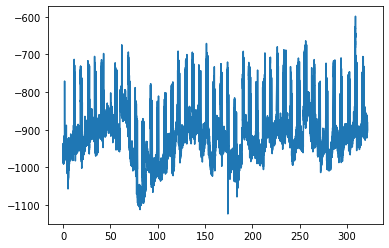

In [62]:
plt.plot(np.arange(0, len(eeg_data[0])/512, 1/512), eeg_data[0])

In [63]:
downsampled_list = []
for sig in eeg_data:
    downsampled_list.append(resample(sig, eeg_data.shape[1]//512 * 128))
resampled_signal = np.array(downsampled_list)
resampled_signal.shape

(61, 41088)

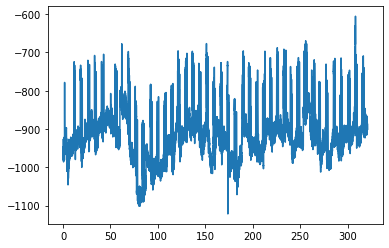

In [73]:
plt.plot(np.arange(0, len(resampled_signal[0])/128, 1/128), resampled_signal[0])

In [41]:
b, a = butter_bandpass(0.3, 3, 256, 4)
filtered_list = []
for sig in resampled_signal:
    filtered_list.append(filtfilt(b, a, sig))

filtered_signal = np.array(filtered_list)

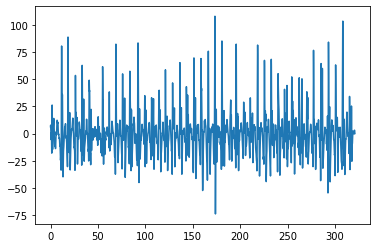

In [74]:
plt.plot(np.arange(0, len(filtered_signal[0])/128, 1/128), filtered_signal[0])

In [43]:
for i in range(filtered_signal.shape[1]):
    mean = filtered_signal[:, i].mean()
    filtered_signal[:, i] -= mean

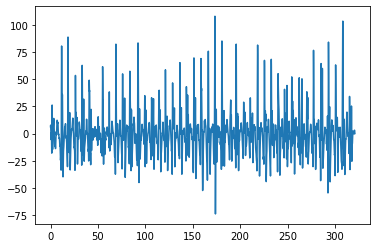

In [75]:
plt.plot(np.arange(0, len(filtered_signal[0])/128, 1/128), filtered_signal[0])